In [82]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from cleaning_script import NOMINAL, ORDINAL, CONTINUOUS, DISCRETE, return_plot, plot_important_features
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

### Read in Data

In [47]:
%store -r correlative_factors
%store -r outlier_cols
correlative_factors.pop('saleprice', None)

# training data
house_train = pd.read_csv('../datasets/house_train_improved.csv')
# testing data
house_test = pd.read_csv('../datasets/house_test_improved.csv')
# increase column width
pd.set_option('display.max_columns', 300)

In [48]:
house_train = house_train.query('gr_liv_area < 4000')

In [49]:
house_train.shape

(2049, 140)

In [50]:
drop = []

### Polytransformation

In [51]:
poly_columns = ['gr_liv_area', 'overall_qual_cond']   
def poly_features(df):
    for x in poly_columns:
        df[x+'_poly'] = df[x]**2
poly_features(house_train)
poly_features(house_test)

In [52]:
# add '_poly to poly_columns
poly_columns = [x+'_poly' for x in poly_columns]


### Log and Sqrt Transformations of Skewed Features

In [53]:
### Feature Transformation

sqrt_vars = ['total_bsmt_sf', 'house_age', 'garage_age']
for col in sqrt_vars:
    house_train[col] = np.sqrt(house_train[col])
    house_test[col] = np.sqrt(house_test[col])

log_vars = ['lot_area', 'lot_frontage', 'gr_liv_area']
for col in log_vars:
    house_train[col] = np.log(house_train[col])
    house_test[col] = np.log(house_test[col])
    

### Log Sale Price

In [55]:
house_train.saleprice = np.log(house_train.saleprice)
log_flag = True

In [56]:
correlative_factors = {k:v for k,v in correlative_factors.items() if v not in drop}

In [57]:
FEATURES = correlative_factors.keys()
FEATURES = [x for x in correlative_factors.keys() if x not in drop]
FEATURES+= poly_columns + outlier_cols

In [58]:

X = house_train[FEATURES]
y = house_train.saleprice
X_test = house_test[FEATURES]

X_train, X_val, y_train, y_val = train_test_split(X, y)

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_train = pd.DataFrame(Xs_train, columns = ss.get_feature_names_out())
Xs_val = pd.DataFrame(ss.transform(X_val), columns = ss.get_feature_names_out())

### Instantiate LassoCV Model

In [60]:

mlr_lasso = LassoCV(alphas = np.arange(0.001, 10, 1))
#calculate residuals by creating predictions
mlr_lasso.fit(Xs_train,y_train)
preds = mlr_lasso.predict(Xs_train)
resid = y_train - preds

### Scores

In [61]:
def get_scores(model, standardize=True, log_price=False):
    
    if standardize == True:
        X_train_ = Xs_train
        X_val_ = Xs_val
    else:
        X_train_ = X_train
        X_val_ = X_val

    if log_price == True:
        var_preds = np.exp(preds)
        var_y_train = np.exp(y_train)
    else:
        var_preds = preds
        var_y_train = y_train

    scores_1 = (cross_val_score(model, X_train_, y_train, cv = KFold(n_splits=5,
                                                                 shuffle=True,
                                                                 random_state=42)))
    print('Training R^2 Score: ', model.score(X_train_, y_train))
    print('Training RMSE: ', mean_squared_error(var_preds, var_y_train, squared = False))
    print('Cross Validation R^2 Score: ', scores_1.mean())
    print('Validation R^2 Score', model.score(X_val_, y_val))

get_scores(mlr_lasso, standardize=True, log_price=log_flag)

Training R^2 Score:  0.9126540920719933
Training RMSE:  20951.952541824263
Cross Validation R^2 Score:  0.9036361385846078
Validation R^2 Score 0.9068241050738935


### Plots

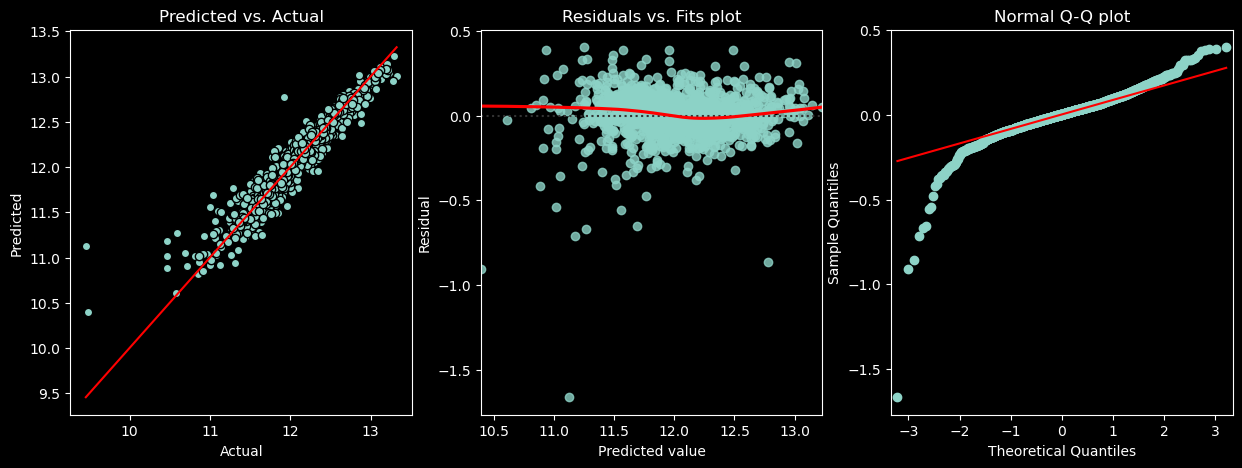

In [62]:
return_plot(preds, y_train, resid)

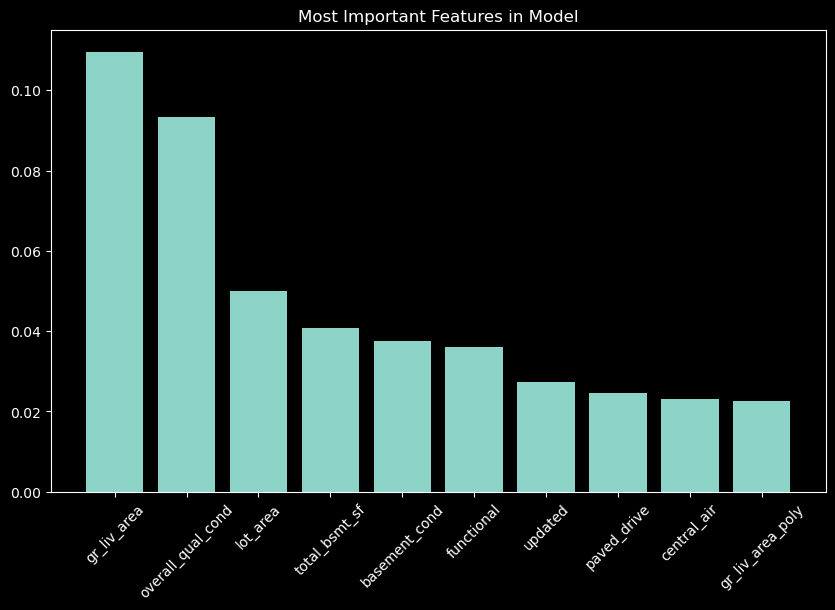

In [63]:
plot_important_features(mlr_lasso, Xs_train, n_features=10)

### Columns Lasso is Minimizing

In [64]:
squashed_columns = []
for idx, item in enumerate(mlr_lasso.coef_):
    if item == 0:
        squashed_columns.append(idx)
    
squashed_columns
Xs_train.iloc[:,squashed_columns].columns

Index(['totrms_abvgrd', 'garage_area', 'fireplace_qu', 'fence', 'Feedr',
       'PConc', 'Slab', '2fmCon', 'Twnhs', 'VinylSd', 'Edwards',
       'has_fireplace', 'overall_qual_cond_poly', 'lot_frontage_outliers',
       'lot_area_outliers', 'mas_vnr_area_outliers', 'total_bsmt_sf_outliers',
       'gr_liv_area_outliers', 'garage_area_outliers'],
      dtype='object')

### Instantiate Ridge Model

In [65]:
mlr_ridge = Ridge()
#calculate residuals by creating predictions
mlr_ridge.fit(Xs_train,y_train)
preds = mlr_ridge.predict(Xs_train)
resid = y_train - preds

### Scores

In [66]:
get_scores(mlr_ridge, standardize=True, log_price=log_flag)

Training R^2 Score:  0.9132598205468444
Training RMSE:  20834.53096192142
Cross Validation R^2 Score:  0.9016811053482439
Validation R^2 Score 0.9045961441154976


### Plots

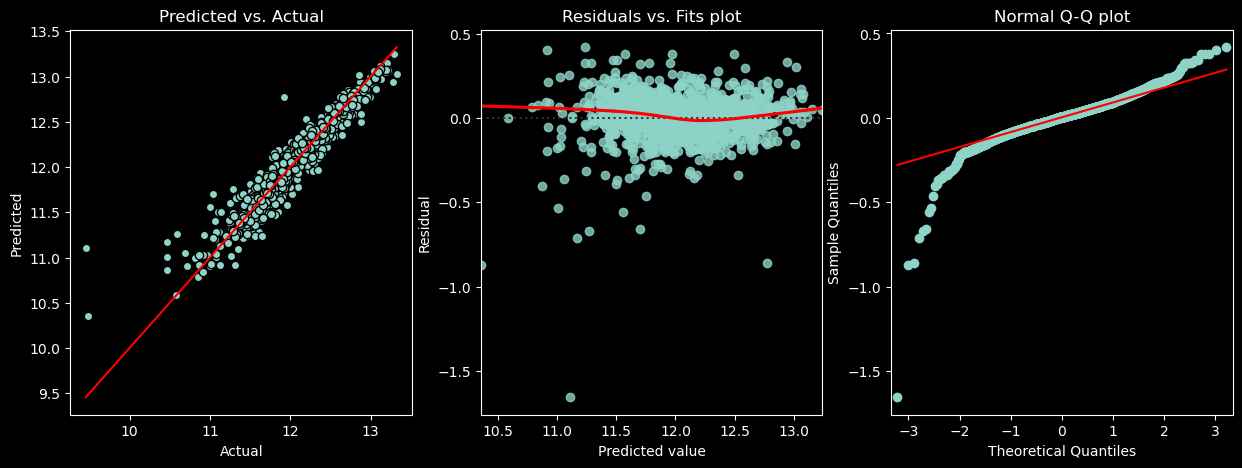

In [67]:
return_plot(preds, y_train, resid)

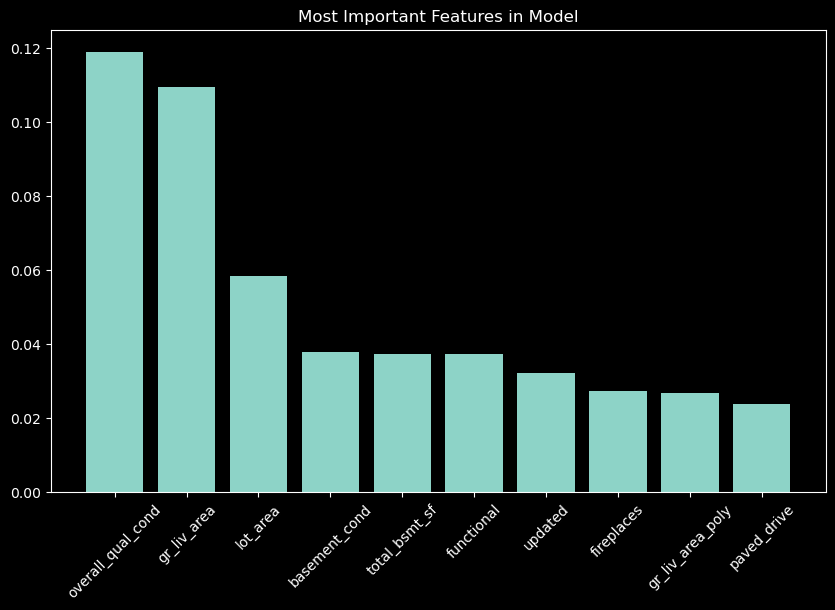

In [68]:
plot_important_features(mlr_ridge, X_train, n_features=10)

### Instantiate OLS Model

In [69]:
mlr_ols = LinearRegression()
#calculate residuals by creating predictions
mlr_ols.fit(Xs_train,y_train)
preds = mlr_ols.predict(Xs_train)
resid = y_train - preds

### Scores

In [70]:
get_scores(mlr_ols, standardize=True, log_price=log_flag)

Training R^2 Score:  0.9132641553215167
Training RMSE:  20862.43559974358
Cross Validation R^2 Score:  0.9010200811175375
Validation R^2 Score 0.904618895484446


### Plots

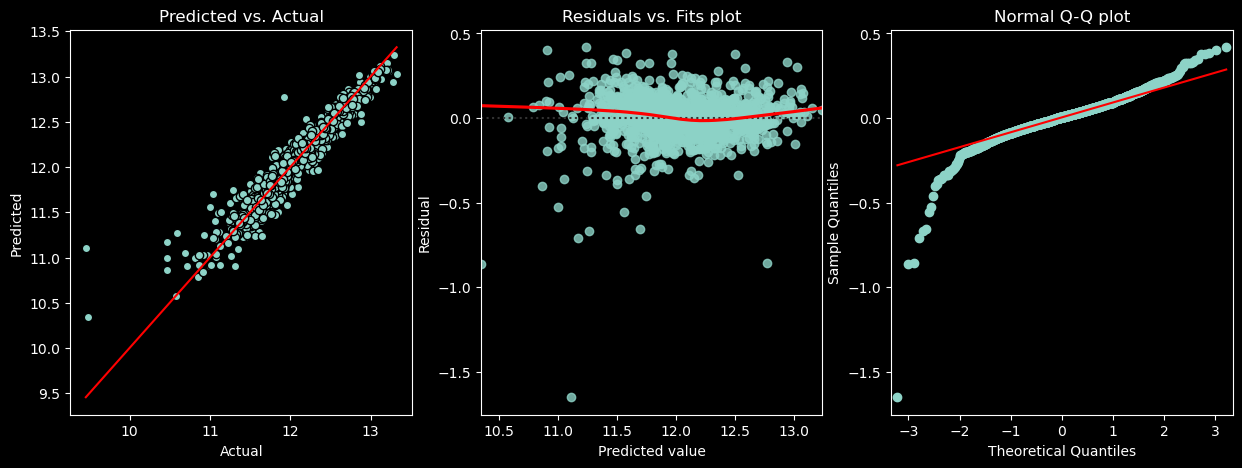

In [71]:
return_plot(preds, y_train, resid)

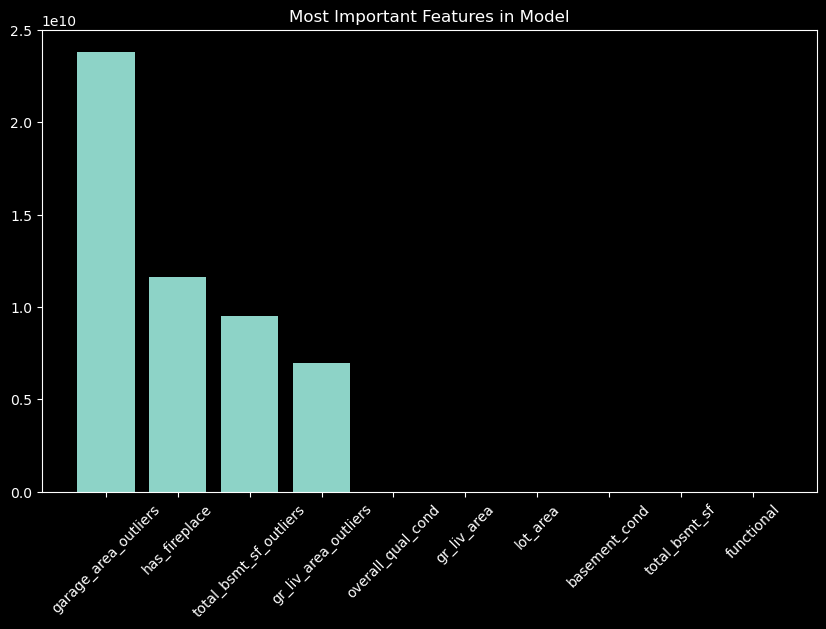

In [72]:
plot_important_features(mlr_ols, X_train, n_features=10)

### Instantiate Elastic Ridge Model

In [83]:
elastic_lr = ElasticNetCV(l1_ratio = np.arange(0.1, 1, 0.1), alphas = np.arange(0.001, 10, 1))
#calculate residuals by creating predictions
elastic_lr.fit(Xs_train,y_train)
preds = elastic_lr.predict(Xs_train)
resid = y_train - preds

### Scores

In [84]:
get_scores(elastic_lr, standardize=True, log_price=log_flag)

Training R^2 Score:  0.9127236984850283
Training RMSE:  20927.401381822114
Cross Validation R^2 Score:  0.903516065808445
Validation R^2 Score 0.9066597949543318


### Plots

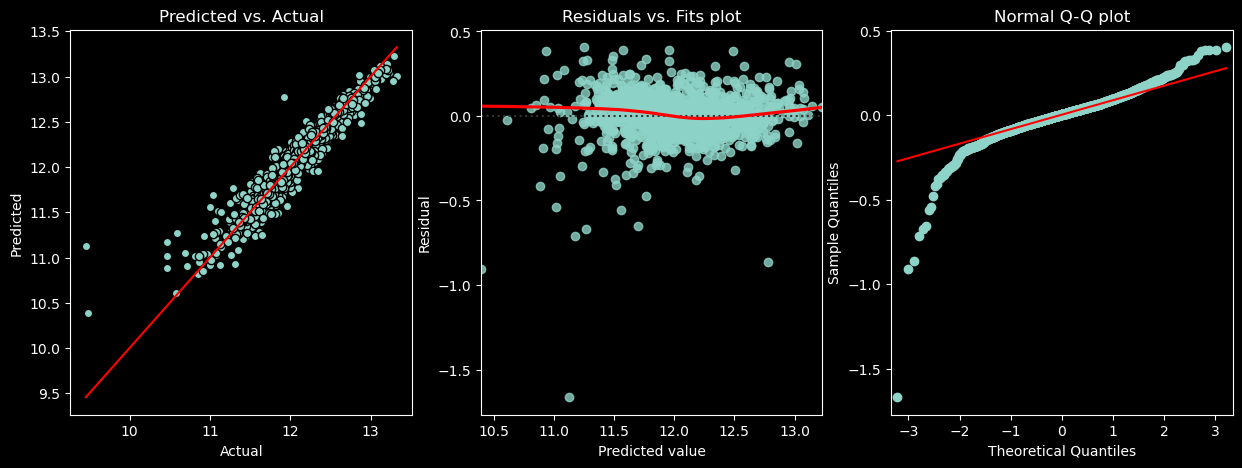

In [85]:
return_plot(preds, y_train, resid)

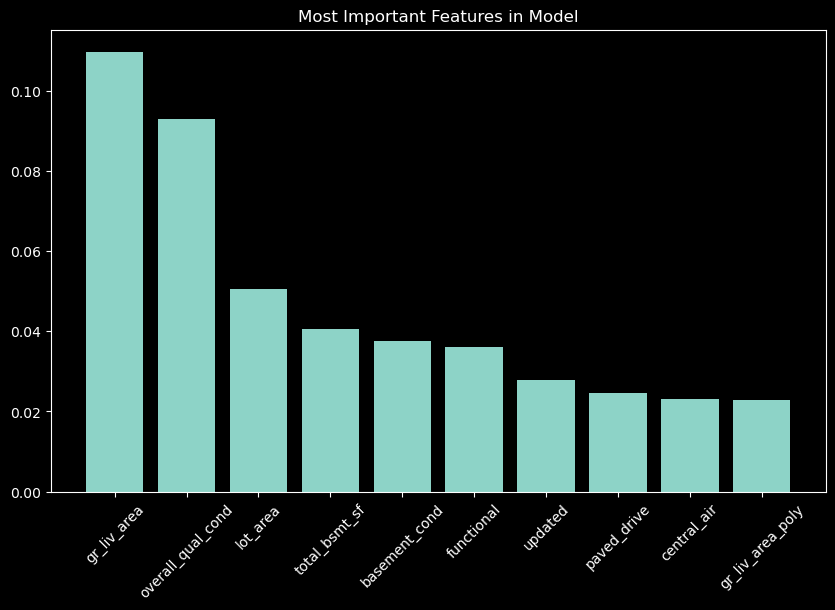

In [86]:
plot_important_features(elastic_lr, X_train, n_features=10)

# Linear Assumptions

Variance Inflation Factor

In [87]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(Xs_train.values, i) for i in range(Xs_train.shape[1])]
vif["features"] = Xs_train.columns;

vif.query('VIF_Factor > 5')

c:\Users\alexs\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF_Factor,features
3,6.522163,fireplaces
4,6.619996,garage_cars
6,8.179801,lot_area
9,12.760940,gr_liv_area
10,6.167399,garage_area
15,inf,fireplace_qu
46,88.097091,overall_qual_cond
51,12.093271,neighborhood_price_rank
55,14.456918,house_age
58,inf,has_fireplace


Statsmodels

In [74]:
X_sm = sm.add_constant(X_train)

res = sm.OLS(y_train, X_sm).fit()
preds = res.predict(sm.add_constant(X_test))
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     250.2
Date:                Thu, 08 Dec 2022   Prob (F-statistic):               0.00
Time:                        02:52:33   Log-Likelihood:                 1045.6
No. Observations:                1536   AIC:                            -1965.
Df Residuals:                    1473   BIC:                            -1629.
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       7.0329      0.235     29.868      0.000       6.571       7.495
bedroom_abvgr              -0.0123      0.006     -1.996      0.046      -0.024      -0.000
kitchen_abvgr              -0.0558      0.028     -1.999      0.046      -0.111      -0.001
totrms_abvgrd              -0.0006      0.004     -0.140      0.888      -0.009       0.008
fireplaces                  0.0426      0.013      3.333      0.001       0.018       0.068
garage_cars                 0.0261      0.011      2.409      0.016       0.005       0.047
lot_frontage                0.0099      0.017      0.592      0.554      -0.023       0.043
lot_area                    0.1137      0.018      6.416      0.000       0.079       0.149
mas_vnr_area             3.333e-05   2.28e-05      1.461      0.144   -1.14e-05    7.81e-05
total_bsmt_sf               0.0046      0.001      6.009      0.000       0.003       0.006
gr_liv_area                 0.3419      0.036      9.592      0.000       0.272       0.412
garage_area             -1.282e-05   3.73e-05     -0.344      0.731   -8.59e-05    6.03e-05
wood_deck_sf                0.0001    2.8e-05      3.642      0.000     4.7e-05       0.000
heating_qc                  0.0162      0.005      3.510      0.000       0.007       0.025
kitchen_qual                0.0293      0.008      3.695      0.000       0.014       0.045
functional                  0.0531      0.005     10.481      0.000       0.043       0.063
fireplace_qu               -0.0088      0.008     -1.092      0.275      -0.024       0.007
paved_drive                 0.0841      0.015      5.788      0.000       0.056       0.113
fence                       0.0003      0.009      0.029      0.977      -0.017       0.018
alley                      -0.0184      0.016     -1.150      0.250      -0.050       0.013
central_air                 0.0867      0.016      5.468      0.000       0.056       0.118
Feedr                       0.0024      0.019      0.130      0.897      -0.035       0.039
Norm                        0.0466      0.013      3.581      0.000       0.021       0.072
PosN                        0.0742      0.031      2.429      0.015       0.014       0.134
CBlock                     -0.0283      0.094     -0.301      0.763      -0.213       0.156
PConc                       0.0013      0.012      0.111      0.912      -0.022       0.024
Slab                       -0.0088      0.035     -0.253      0.800      -0.077       0.059
2fmCon                      0.0092      0.024      0.384      0.701      -0.038       0.056
Duplex                     -0.0071      0.030     -0.233      0.815      -0.067       0.053
Twnhs                       0.0181      0.024      0.754      0.451      -0.029       0.065
CemntBd                     0.0365      0.023  

# Submission

In [75]:
#E instantiate lasso with best alpha 

new_lasso = Lasso(alpha = 0.001)
new_lasso.fit(X,y)

ss = StandardScaler()
Xs_test = ss.fit_transform(X_test)
Xs_test = pd.DataFrame(Xs_test, columns = ss.get_feature_names_out())



price_preds = new_lasso.predict(X_test)
house_test['SalePrice'] = np.exp(price_preds)

house_test
house_test[['id', 'SalePrice']].to_csv('../datasets/submission.csv', index = False)

In [76]:
house_test[['id', 'SalePrice']]


,id,SalePrice
0,2658,113882.467979
1,2718,166901.980425
2,2414,229467.232880
3,1989,113390.384382
4,625,178500.053907
...,...,...
873,1662,178472.263238
874,1234,221192.526155
875,1373,131232.820684
876,1672,113657.981108


In [77]:
current_df = house_test[['id', 'SalePrice']]
best_df = pd.read_csv('../datasets/best_submission.csv')
best_df = best_df.join(current_df.set_index('id'), on='id', lsuffix='_best', rsuffix='_current')
best_df['diff'] = best_df['SalePrice_best'] - best_df['SalePrice_current']
best_df.sort_values('diff', ascending=False)

,id,SalePrice_best,SalePrice_current,diff
793,92,315182.8662,291233.905135,23948.961065
213,957,305442.1591,282727.239993,22714.919107
306,1571,264973.3108,247210.376610,17762.934190
385,1430,206693.8407,188964.798498,17729.042202
771,2617,152785.5560,135512.221141,17273.334859
...,...,...,...,...
257,2401,429896.1054,466705.653112,-36809.547712
525,1692,424294.1843,461669.402086,-37375.217786
115,2446,511529.0098,593764.258439,-82235.248639
170,1761,564067.5912,703912.463230,-139844.872030


In [78]:
ids = [1761, 2216, 1768]

In [79]:
house_test.query('id in @ids')

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_cond,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_cond,foundation,bsmt_exposure,total_bsmt_sf,heating,heating_qc,central_air,electrical,gr_liv_area,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_finish,garage_cars,garage_area,paved_drive,wood_deck_sf,pool_area,fence,misc_val,mo_sold,sale_type,Feedr,Norm,PosA,PosN,RRAe,RRAn,RRNe,RRNn,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,Greens,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,2fmCon,Duplex,Twnhs,TwnhsE,AsphShn,BrkComm,BrkFace,CemntBd,HdBoard,MetalSd,Plywood,Stucco,VinylSd,Wd Sdng,WdShing,CBlock,PConc,Slab,Stone,Wood,Tar&Grv,WdShake,WdShngl,NoSewr,Feedr.1,Norm.1,PosA.1,PosN.1,RRAe.1,RRAn.1,RRNe.1,RRNn.1,overall_qual_cond,basement_cond,2nd_story,total_bath,total_porch_sf,neighborhood_price_rank,updated,garage_age,garage_qual_cond,house_age,land_house_ratio,has_pool,has_fireplace,meltdown,lot_frontage_outliers,lot_area_outliers,mas_vnr_area_outliers,total_bsmt_sf_outliers,gr_liv_area_outliers,garage_area_outliers,gr_liv_area_poly,overall_qual_cond_poly,SalePrice
170,1761,528320050,60,RL,5.075174,9.656499,Pave,0,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,5,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,2,PConc,NaN,48.948953,GasA,4,1,SBrkr,8.406485,4,1,4,10,3,2,1,Attchd,Fin,3,813,1,171,555,1,0,7,WD,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6.5,12.0,1,4.5,78,2,0,3.316625,2.0,3.316625,3.490393,1,1,0,1,1,1,1,1,1,20034576,42.25,703912.463230
463,1768,528351010,60,RL,4.644391,9.977435,Pave,0,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,6,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,2,PConc,3.0,49.436828,GasA,4,1,SBrkr,8.370084,4,1,4,10,3,2,1,Attchd,Fin,3,832,1,382,0,0,0,1,WD,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,7.0,12.0,1,4.0,50,2,1,3.605551,2.0,3.605551,4.989574,0,1,0,0,0,0,0,0,0,18627856,49.00,770876.812015


<AxesSubplot:xlabel='SalePrice_best', ylabel='id'>

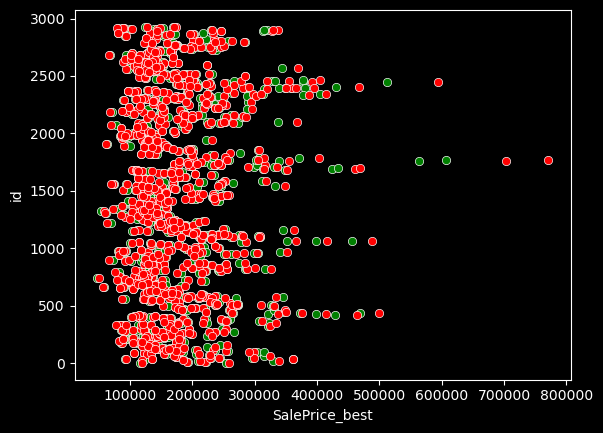

In [80]:
sns.scatterplot(best_df, x = 'SalePrice_best', y = 'id', color = 'green')
sns.scatterplot(best_df, x = 'SalePrice_current', y = 'id', color = 'red')
